In [1]:
%matplotlib notebook
import json
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt

if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    # Not Python 3 - today, it is most likely to be Python 2
    # But note that this might need an update when Python 4
    # might be around one day
    from urllib import urlopen


In [2]:
# connect to poloniex's API
CURRENCIES = ['USDT_BTC', 'USDT_LTC', 'USDT_ETH', 'USDT_XRP']
url = 'https://poloniex.com/public?command=returnChartData&currencyPair=$C&start=1356998100&end=9999999999&period=300'
urls = [url.replace('$C', c) for c in CURRENCIES]

for i, c in enumerate(CURRENCIES):
    with urlopen(urls[i]) as url:
        r = url.read()
        d = json.loads(r.decode())
        df = pd.DataFrame(d)
        #print(df.columns)
        df.to_pickle('data/poloniex/' + c + '.pkl')
        print('Successfully downloaded', c)

Index(['close', 'date', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage'],
      dtype='object')
Successfully downloaded USDT_BTC
Index(['close', 'date', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage'],
      dtype='object')
Successfully downloaded USDT_LTC
Index(['close', 'date', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage'],
      dtype='object')
Successfully downloaded USDT_ETH
Index(['close', 'date', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage'],
      dtype='object')
Successfully downloaded USDT_XRP


In [2]:
btc_df = pd.read_pickle('data/poloniex/USDT_BTC.pkl')
class PastSampler:

    def __init__(self, N, K, sliding_window = True):
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        print(I)
        print(I.shape)
        
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

In [3]:
btc_df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,225.0,1424373000,0.33,225.0,0.33,0.004444,0.999999,225.0
1,225.0,1424373300,225.00,225.0,225.00,0.000000,0.000000,225.0
2,225.0,1424373600,225.00,225.0,225.00,0.000000,0.000000,225.0
3,225.0,1424373900,225.00,225.0,225.00,0.000000,0.000000,225.0
4,225.0,1424374200,225.00,225.0,225.00,0.000000,0.000000,225.0


In [60]:
import sklearn.preprocessing as prep
scaler = prep.MinMaxScaler()
#print(btc_df.as_matrix().shape)
#print(btc_df.as_matrix(), '#')
#print('#', np.array(scaler.fit_transform(btc_df))[:,None,:], '#')
#print(btc_df.shape)
original_A = np.array(btc_df)[:,None,:]
A = np.array(scaler.fit_transform(btc_df))[:,None,:]
print(original_A.shape)
print(A.shape)
#print(prep.MinMaxScaler().fit_transform(A.reshape(-1,8)))
#print(A[1,0,:])
#print(scaler.inverse_transform(A.reshape(-1,8)), '#')
#print(scaler.get_params())


(319870, 1, 8)
(319870, 1, 8)


In [147]:
NPS, NFS = 256, 32         #Number of past and future samples
ps = PastSampler(NPS, NFS, sliding_window=True)
datas, labels = ps.transform(A)
print(datas.shape, labels.shape)

labels = labels[:,:,0].reshape(-1, NFS, 1)
print(labels.shape)

[[     0      1      2 ...    285    286    287]
 [     1      2      3 ...    286    287    288]
 [     2      3      4 ...    287    288    289]
 ...
 [319580 319581 319582 ... 319865 319866 319867]
 [319581 319582 319583 ... 319866 319867 319868]
 [319582 319583 319584 ... 319867 319868 319869]]
(319583, 288)
(319583, 256, 8) (319583, 32, 8)
(319583, 32, 1)


In [159]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.layers import CuDNNLSTM, LSTM, LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint

step_size = datas.shape[1]
units = 50
second_units = 30
batch_size = NPS
nb_features = datas.shape[2]
epochs = 20
output_size = NFS
#split training validation
training_size = int(0.9 * datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:,0]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:,0]


#build model
#if CuDNNLSTM is not working, use LSTM
model = Sequential()
model.add(CuDNNLSTM(units=units, input_shape=(step_size,nb_features),return_sequences=False))
model.add(Dropout(0.8))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 50)                12000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1632      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)                0         
Total params: 13,632
Trainable params: 13,632
Non-trainable params: 0
_________________________________________________________________


In [160]:
model.fit(
    training_datas, 
    training_labels, 
    batch_size=batch_size,
    validation_split=0.2,
    #validation_data=(validation_datas,validation_labels), 
    epochs=epochs,
    verbose=2,
    callbacks=[
        CSVLogger(output_file_name+'.csv', append=True)#,
        #ModelCheckpoint('nn_models/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', verbose=1)
    ])

Train on 230099 samples, validate on 57525 samples
Epoch 1/20
 - 37s - loss: 1.7975e-04 - val_loss: 0.0016
Epoch 2/20
 - 37s - loss: 2.7781e-05 - val_loss: 8.3214e-04
Epoch 3/20
 - 37s - loss: 2.1813e-05 - val_loss: 8.3392e-04
Epoch 4/20
 - 37s - loss: 1.9625e-05 - val_loss: 6.9758e-04
Epoch 5/20
 - 37s - loss: 1.8303e-05 - val_loss: 7.4037e-04
Epoch 6/20
 - 37s - loss: 1.7747e-05 - val_loss: 7.8028e-04
Epoch 7/20
 - 38s - loss: 1.7482e-05 - val_loss: 9.0544e-04
Epoch 8/20
 - 38s - loss: 1.7157e-05 - val_loss: 0.0011
Epoch 9/20
 - 38s - loss: 1.7153e-05 - val_loss: 9.0264e-04
Epoch 10/20
 - 38s - loss: 1.6978e-05 - val_loss: 9.3770e-04
Epoch 11/20
 - 38s - loss: 1.6844e-05 - val_loss: 7.9128e-04
Epoch 12/20
 - 38s - loss: 1.6991e-05 - val_loss: 4.1768e-04
Epoch 13/20
 - 38s - loss: 1.6844e-05 - val_loss: 3.6499e-04
Epoch 14/20
 - 38s - loss: 1.7064e-05 - val_loss: 5.9350e-04
Epoch 15/20
 - 38s - loss: 1.6837e-05 - val_loss: 5.1996e-04
Epoch 16/20
 - 38s - loss: 1.6733e-05 - val_loss: 3

In [161]:
model.save('nn_models/btc_10_epochs.h5')

In [162]:
original_A.reshape(-1,8)[:,0].shape

(319870,)

In [163]:
scaler2 = prep.MinMaxScaler()
scaler2.fit_transform(original_A.reshape(-1,8)[:,0].reshape(-1,1))
vd = validation_datas[0:len(validation_datas):NPS,:,:]

predicted = model.predict(vd)

vd = scaler.inverse_transform(vd.reshape(-1,8))

<IPython.core.display.Javascript object>


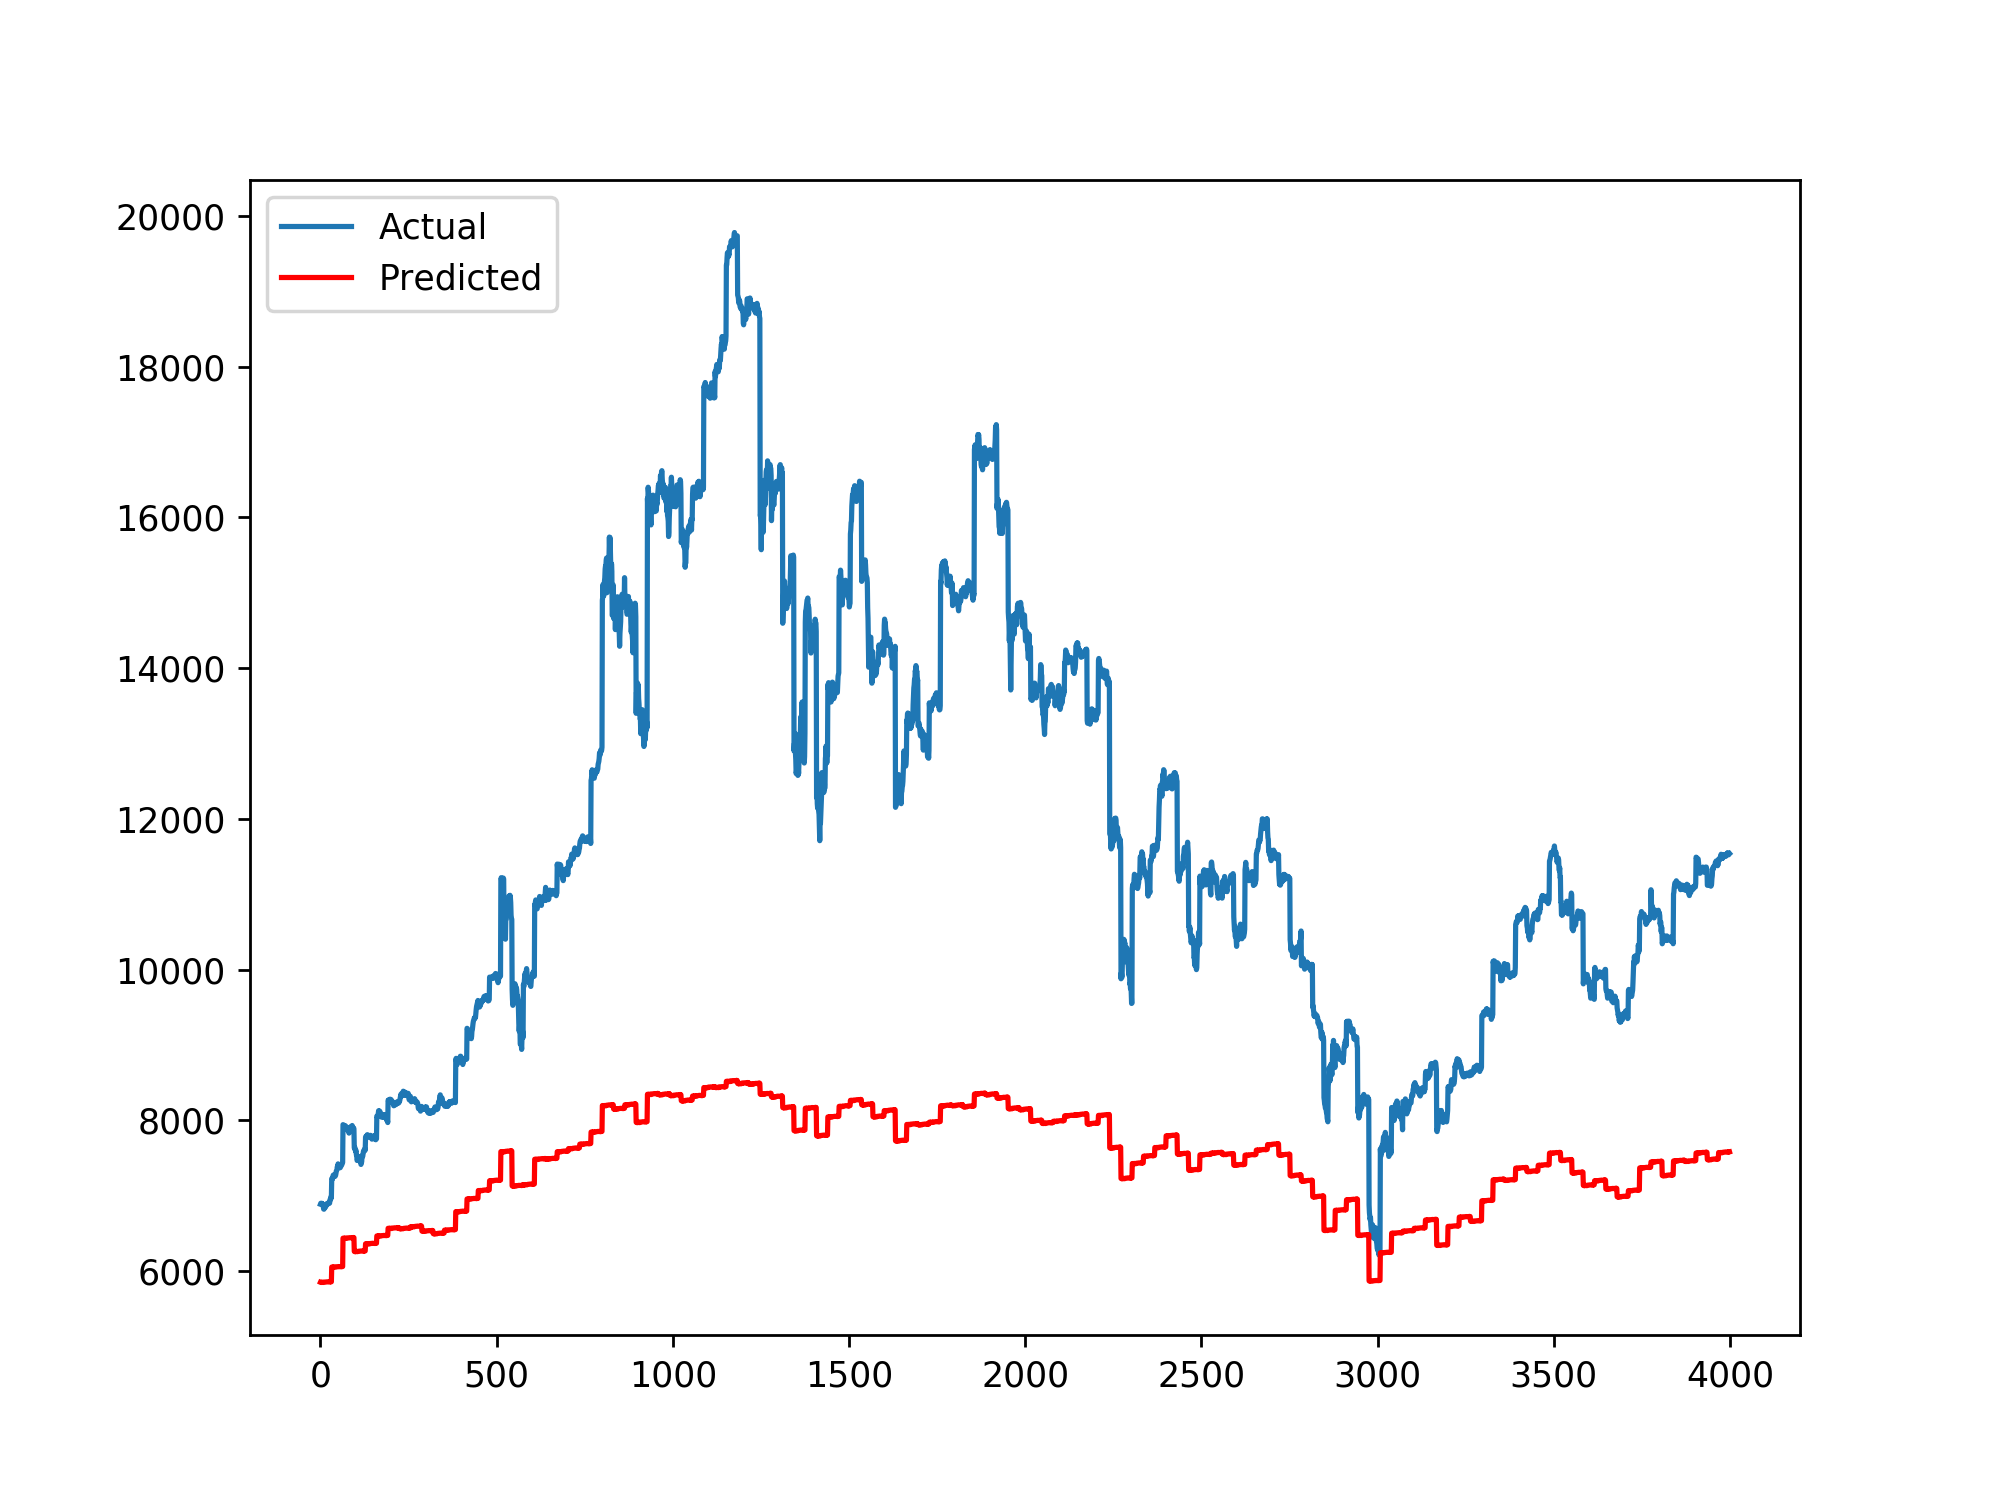

In [164]:
predict = predicted.reshape(-1,1)
truth = validation_labels[0:len(validation_labels):NPS,:].reshape(-1,1)

predict = scaler2.inverse_transform(predict)
truth = scaler2.inverse_transform(truth)

plt.figure(figsize=(8,6))
plt.plot(truth, label = 'Actual')
plt.plot(predict, 'r', label='Predicted')
plt.legend(loc='upper left')
plt.show()